In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [3]:
df['annual_income'] = pd.to_numeric(df['annual_income'], errors='coerce')
df.annual_income = df.annual_income.fillna(0.0)
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

categorical = [
    'lead_source',
    'industry',
    'employment_status',
    'location',
]
for c in categorical:
    df[c] = df[c].fillna('NA')

numerical = list(df.dtypes[df.dtypes != 'object'].index)
for n in numerical:
    df[n] = df[n].fillna('0.0')

df.isnull().sum()


lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [4]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [7]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [8]:
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
for col in numerical:
    df_train[col] = pd.to_numeric(df_train[col], errors='coerce').fillna(0.0)
    df_val[col]   = pd.to_numeric(df_val[col],   errors='coerce').fillna(0.0)
    df_test[col]  = pd.to_numeric(df_test[col],  errors='coerce').fillna(0.0)

y_train = df_train['converted'].astype(int).values
y_val   = df_val['converted'].astype(int).values
y_test  = df_test['converted'].astype(int).values

del df_train['converted']
del df_val['converted']
del df_test['converted']

from sklearn.metrics import roc_auc_score
for col in numerical:
    score = roc_auc_score(y_train, df_train[col].values)
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[col].values)
    print(col, score)

number_of_courses_viewed 0.7635680590007088
annual_income 0.5519578313253012
interaction_count 0.738270176293409
lead_score 0.6144993577250176


In [9]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [10]:
features = numerical + categorical

In [11]:
for col in numerical:
    df_train[col] = pd.to_numeric(df_train[col], errors='coerce').fillna(0.0)
    df_val[col]   = pd.to_numeric(df_val[col],   errors='coerce').fillna(0.0)
    df_test[col]  = pd.to_numeric(df_test[col],  errors='coerce').fillna(0.0)

In [12]:
dv = DictVectorizer(sparse=False)


In [13]:
train_dicts = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = df_test[features].to_dict(orient='records')
X_test = dv.transform(test_dicts)


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

In [15]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict_proba(X_val_scaled)[:, 1]

In [16]:
auc_save = roc_auc_score(y_val, y_pred)
auc_save.__round__(3)

0.92

C:\Users\user\PycharmProjects\mlcamp-homework\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


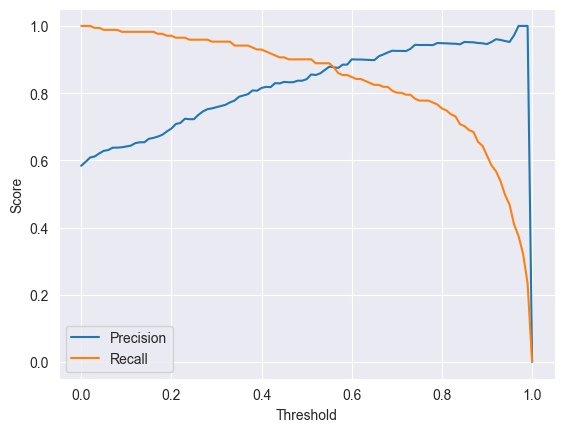

Precision≈Recall at threshold: 0.56


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    preds = (y_pred >= t)
    precisions.append(precision_score(y_val, preds))
    recalls.append(recall_score(y_val, preds))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# find threshold where precision and recall intersect (or are closest)
diff = np.abs(np.array(precisions) - np.array(recalls))
best_threshold = thresholds[np.argmin(diff)]
print("Precision≈Recall at threshold:", round(best_threshold, 3))

In [18]:
f1_scores = []

for p, r in zip(precisions, recalls):
    if p + r == 0:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print("Best threshold:", round(best_threshold, 3))
print("Max F1:", round(best_f1, 3))

Best threshold: 0.55
Max F1: 0.884


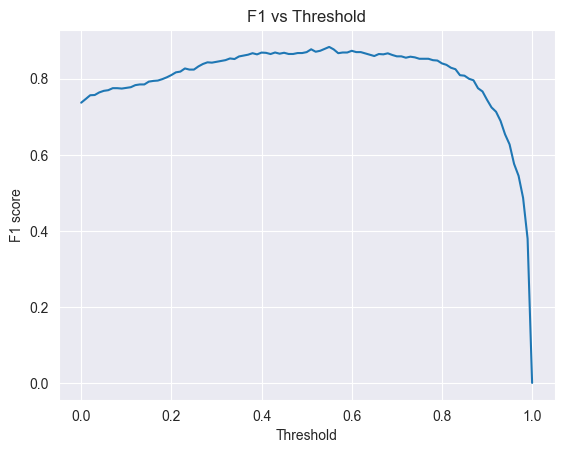

In [19]:
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('F1 vs Threshold')
plt.grid(True)
plt.show()

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df['annual_income'] = pd.to_numeric(df['annual_income'], errors='coerce').fillna(0.0)
for c in list(df.dtypes[df.dtypes == 'object'].index):
    df[c] = df[c].fillna('NA')
for n in list(df.dtypes[df.dtypes != 'object'].index):
    df[n] = df[n].fillna(0.0)

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count']
categorical = ['lead_source', 'industry', 'employment_status', 'location']
features = numerical + categorical

kf = KFold(n_splits=5, shuffle=True, random_state=1)
Cs = [0.000001, 0.001, 1.0]

results = {}

for C in Cs:
    fold_aucs = []
    for train_idx, val_idx in kf.split(df_full_train):
        # split
        df_train = df_full_train.iloc[train_idx].reset_index(drop=True)
        df_val   = df_full_train.iloc[val_idx].reset_index(drop=True)

        y_train = df_train['converted'].astype(int).values
        y_val   = df_val['converted'].astype(int).values
        del df_train['converted']
        del df_val['converted']

        for col in numerical:
            df_train[col] = pd.to_numeric(df_train[col], errors='coerce').fillna(0.0)
            df_val[col]   = pd.to_numeric(df_val[col], errors='coerce').fillna(0.0)


        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(df_train[features].to_dict(orient='records'))
        X_val   = dv.transform(df_val[features].to_dict(orient='records'))

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        fold_aucs.append(auc)

    fold_aucs = np.array(fold_aucs)
    mean_auc = fold_aucs.mean()
    std_auc  = fold_aucs.std()
    results[C] = (mean_auc, std_auc)
    print(f"C = {C}  -> mean AUC = {mean_auc:.6f}, std = {std_auc:.6f}")

print("\nRounded (mean, std) to 3 decimals:")
for C, (m, s) in results.items():
    print(f"C = {C} -> mean = {round(m,3)}, std = {round(s,3)}")


best = None
for C, (m, s) in results.items():
    if best is None:
        best = (C, m, s)
    else:
        if m > best[1] + 1e-12:
            best = (C, m, s)
        elif abs(m - best[1]) < 1e-12:
            if s < best[2] - 1e-12:
                best = (C, m, s)
            elif abs(s - best[2]) < 1e-12:
                if C < best[0]:
                    best = (C, m, s)

print("\nBest C according to rules:", best[0], "mean =", round(best[1],3), "std =", round(best[2],3))

C = 1e-06  -> mean AUC = 0.560301, std = 0.023765
C = 0.001  -> mean AUC = 0.865458, std = 0.029348
C = 1.0  -> mean AUC = 0.821413, std = 0.035842

Rounded (mean, std) to 3 decimals:
C = 1e-06 -> mean = 0.56, std = 0.024
C = 0.001 -> mean = 0.865, std = 0.029
C = 1.0 -> mean = 0.821, std = 0.036

Best C according to rules: 0.001 mean = 0.865 std = 0.029
